In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import pickle
import io
import os
import glob
import time

camera = pickle.load(open("camera_matrix.pkl", "rb"))
mtx = camera['mtx']
dist = camera['dist']
camera_img_size = camera['imagesize']

In [2]:
def undistort(img, mtx, dist, camera_img_size):
    img_size1 = (img.shape[1], img.shape[0])
    assert (img_size1 == camera_img_size), 'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx)
    return undist

In [30]:
img = mpimg.imread('calibration4.jpg')
img_size1 = (img.shape[1], img.shape[0])

undist = undistort(img, mtx, dist, img_size1)

'''
#Visualize the distorted and undistorted images
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Captured Image', fontsize = 30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize = 30)
plt.tight_layout()
'''

"\n#Visualize the distorted and undistorted images\nplt.figure()\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))\nax1.imshow(img)\nax1.set_title('Captured Image', fontsize = 30)\nax2.imshow(undist)\nax2.set_title('Undistorted Image', fontsize = 30)\nplt.tight_layout()\n"

In [32]:
def sobel_filter(img, orient='x', thresh=(0,255)):
    start_time = time.time()
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    print(time.time() - start_time)
    
    return binary_output

0.022940635681152344


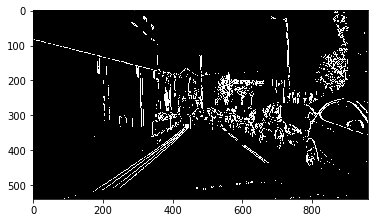

In [49]:
# set color map to gray, default is RGB
image = mpimg.imread('test0.jpg')
img_size1 = (image.shape[1], image.shape[0])
undist_image = undistort(image, mtx, dist, img_size1)

plt.imshow(sobel_filter(undist_image, thresh=(20,110)),  cmap='gray');

In [40]:
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the xy magnitude 
    mag = np.sqrt(x**2 + y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.max(mag)/255
    eightbit = (mag/scale).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(eightbit)
    binary_output[(eightbit > thresh[0]) & (eightbit < thresh[1])] =1 
    return binary_output

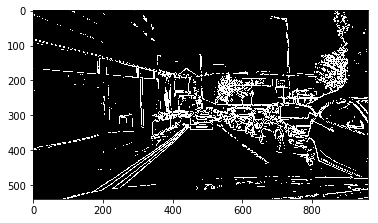

In [41]:
plt.imshow(mag_threshold(undist_image, thresh=(20,100)),  cmap='gray');

In [7]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(y, x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

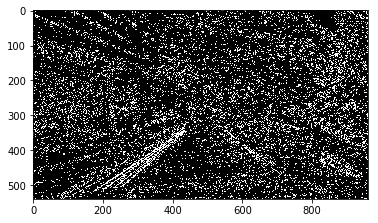

In [42]:
plt.imshow(dir_threshold(undist_image, thresh=(0.8,1.2)),  cmap='gray');

In [43]:
def hls_select(img, sthresh=(0, 255),lthresh=()):
    # 1) Convert to HLS color space
    hls_img = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S >= sthresh[0]) & (S <= sthresh[1])
                 & (L > lthresh[0]) & (L <= lthresh[1])] = 1
    return binary_output

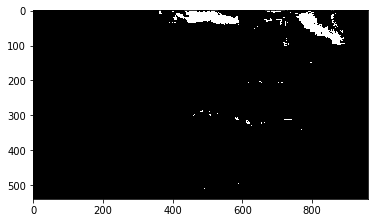

In [44]:
plt.imshow(hls_select(undist_image, sthresh=(140,255), lthresh=(120, 255)),  cmap='gray');

In [45]:
def red_select(img, thresh=(0, 255)):
    # Apply a threshold to the R channel
    R = img[:,:,0]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_output

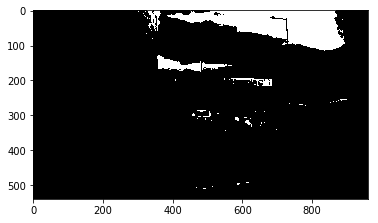

In [46]:
plt.imshow(red_select(undist_image, thresh=(200,255)),  cmap='gray');

In [47]:
def binary_pipeline(img):
    start_time = time.time()
    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    #img_copy = np.copy(img)
    
    # color channels
    s_binary = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    #red_binary = red_select(img_copy, thresh=(200,255))
    
    # Sobel x
    x_binary = sobel_filter(img_copy,thresh=(25, 200))
    y_binary = sobel_filter(img_copy,thresh=(25, 200), orient='y')
    xy = cv.bitwise_and(x_binary, y_binary)
    
    #magnitude & direction
    mag_binary = mag_threshold(img_copy, sobel_kernel=3, thresh=(30,100))
    dir_binary = dir_threshold(img_copy, sobel_kernel=3, thresh=(0.8, 1.2))
    
    # Stack each channel
    gradient = np.zeros_like(s_binary)
    gradient[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    final_binary = cv.bitwise_or(s_binary, gradient)
    print(time.time() - start_time)
    return final_binary

0.024933576583862305
0.02094292640686035
0.13663268089294434


<Figure size 432x288 with 0 Axes>

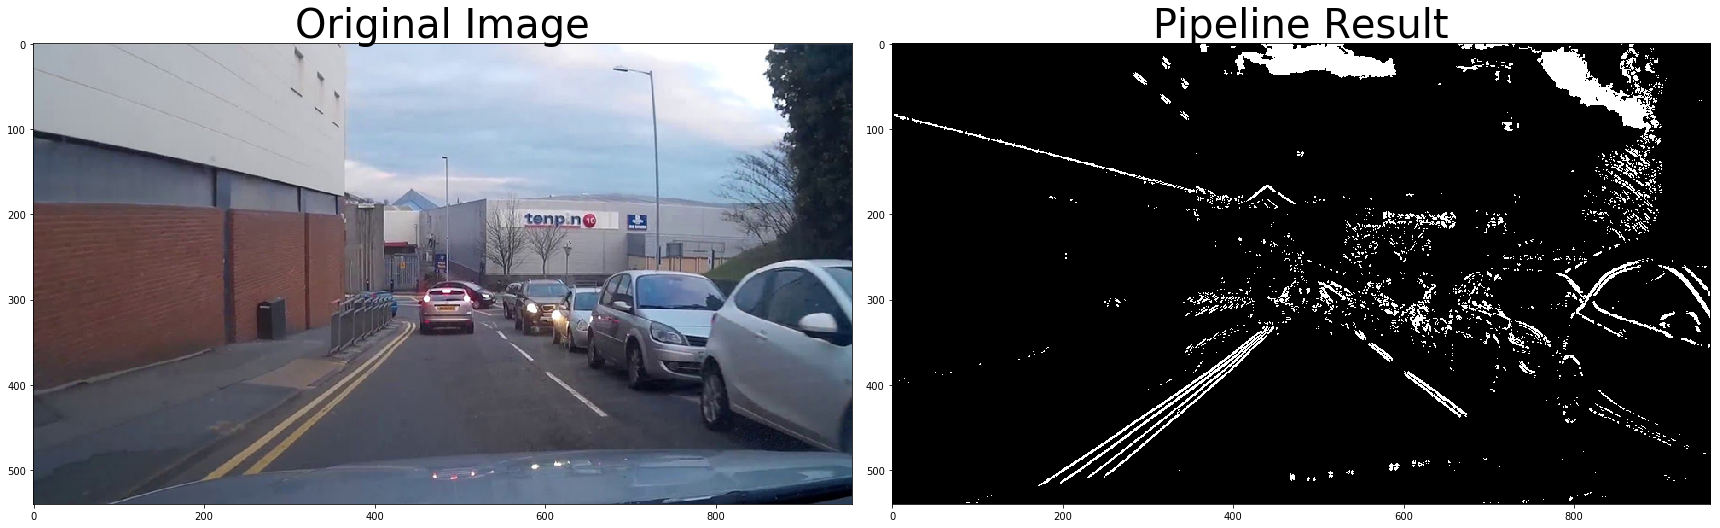

In [48]:
result = binary_pipeline(undist_image)

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()

In [15]:
def warp_image(img):
    
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    #the "order" of points in the polygon you are defining does not matter
    #but they need to match the corresponding points in destination_points!
    source_points = np.float32([
    [0.117 * x, y],
    [(0.5 * x) - (x*0.078), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ])

#     #chicago footage
#     source_points = np.float32([
#                 [300, 720],
#                 [500, 600],
#                 [700, 600],
#                 [850, 720]
#                 ])
    
#     destination_points = np.float32([
#                 [200, 720],
#                 [200, 200],
#                 [1000, 200],
#                 [1000, 720]
#                 ])
    
    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    
    #print(source_points)
    #print(destination_points)
    
    return warped_img, inverse_perspective_transform

<Figure size 432x288 with 0 Axes>

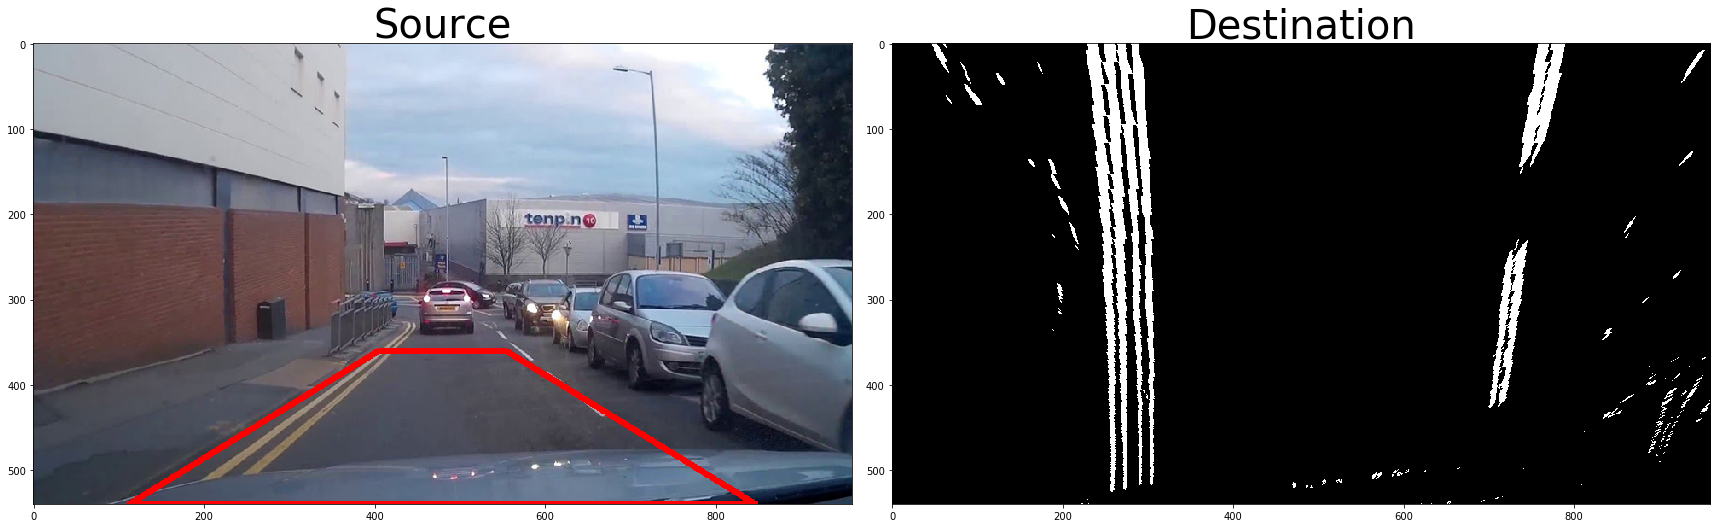

In [16]:
birdseye_result, inverse_perspective_transform = warp_image(result)

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image.shape[1], image.shape[0])
x = image.shape[1]
y = image.shape[0]
source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.078), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

draw_poly = cv.polylines(image,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()

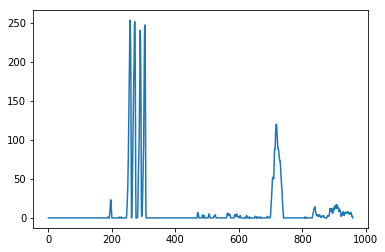

In [17]:
#look at only lower half of image
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure()
plt.plot(histogram)

In [18]:
def track_lanes_initialize(binary_warped):
    
    global window_search
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half 
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

In [19]:
left_fit,right_fit = track_lanes_initialize(birdseye_result)

In [20]:
def track_lanes_update(binary_warped, left_fit,right_fit):

    global window_search
    global frame_count
    
    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True
   
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fit,right_fit,leftx,lefty,rightx,righty

In [21]:
global frame_count
frame_count=0
left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye_result, left_fit,right_fit)

In [22]:
# A function to get quadratic polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

In [23]:
def lane_fill_poly(binary_warped,undist,left_fit,right_fit):
    
    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane 
    cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    return result

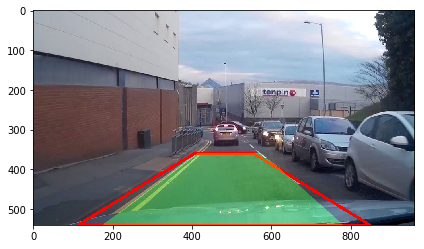

In [24]:
colored_lane = lane_fill_poly(birdseye_result, image, left_fit, right_fit)
plt.figure()
plt.imshow(colored_lane);
plt.tight_layout()

In [25]:
def measure_curve(binary_warped,left_fit,right_fit):
        
    # generate y values 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # measure radius at the maximum y value, or bottom of the image
    # this is closest to the car 
    y_eval = np.max(ploty)
    
    # coversion rates for pixels to metric
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # x positions lanes
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials in metric 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)
    
    return curve_rad

In [26]:
measure_curve(birdseye_result,left_fit, right_fit)

3554.0

In [27]:
def vehicle_offset(img,left_fit,right_fit):
    
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    xm_per_pix = 3.7/700 
    image_center = img.shape[1]/2
    
    ## find where lines hit the bottom of the image, closest to the car
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)
    
    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0
    
    ## vehicle offset
    distance = image_center - lane_center
    
    ## convert to metric
    return (round(distance*xm_per_pix,5))

In [28]:
offset = vehicle_offset(colored_lane, left_fit, right_fit)
print(offset)

0.00864


In [29]:
def img_pipeline(undist):
    
    global window_search
    global left_fit_prev
    global right_fit_prev
    global frame_count
    global curve_radius
    global offset
        
    # load camera matrix and distortion matrix
    camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
    mtx = camera['mtx']
    dist = camera['dist']
    camera_img_size = camera['imagesize']
    
    #correct lens distortion
    #undist = undistort(img,mtx,dist,camera_img_size)
    # get binary image

    binary_img = binary_pipeline(undist)

    #perspective transform
    birdseye, inverse_perspective_transform = warp_image(binary_img)
    
    if window_search:
        #window_search = False
        #window search
        left_fit,right_fit = track_lanes_initialize(birdseye)
        #store values
        left_fit_prev = left_fit
        right_fit_prev = right_fit
        
    else:
        #load values
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        #search in margin of polynomials
        left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye, left_fit,right_fit)
    
    #save values
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    

    #draw polygon
    processed_frame = lane_fill_poly(birdseye, undist, left_fit, right_fit)
 
    #update ~twice per second
    if frame_count==0 or frame_count%7==0:
        #measure radii
        curve_radius = measure_curve(birdseye,left_fit,right_fit)
        #measure offset
        offset = vehicle_offset(undist, left_fit, right_fit)  
        
    #printing information to frame
    font = cv.FONT_HERSHEY_TRIPLEX
    processed_frame = cv.putText(processed_frame, 'Radius: '+str(curve_radius)+' m', (30, 40), font, 1, (0,255,0), 2)
    processed_frame = cv.putText(processed_frame, 'Car Position: '+str(offset)+' m', (30, 80), font, 1, (0,255,0), 2)
   
    frame_count += 1
    return processed_frame

In [30]:
lane_image = img_pipeline(image)
mpimg.imsave('lane_',lane_image)

0.12865424156188965


In [31]:
cap = cv.VideoCapture('project_video.mp4')

while(True):
    ret, frame = cap.read()
    lane_frame = img_pipeline(frame)
    cv.imshow('frame', lane_frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

0.21841812133789062
0.21546339988708496
0.20744800567626953
0.22341489791870117
0.23138904571533203
0.25232529640197754
0.22838878631591797
0.22440290451049805
0.1984715461730957
0.22639966011047363
0.2064497470855713
0.2014608383178711
0.20545387268066406
0.20445466041564941
0.21146368980407715
0.19946789741516113
0.1984720230102539
0.19448208808898926
0.20046687126159668
0.19348573684692383
